<a href="https://colab.research.google.com/github/Anushkajoshi000/onjectdetection_openVINO/blob/main/object_detection_using_openVino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q "openvino-dev>=2023.0.0" "numpy>=1.21.0" "opencv-python" "matplotlib>=3.6.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.5 MB/s eta 0:00:00


In [2]:
# Fetch the notebook utils script from the openvino_notebooks repo
import urllib.request

urllib.request.urlretrieve(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py",
    filename="notebook_utils.py",
);

In [4]:
# Standard python modules
from pathlib import Path

# External modules and dependencies
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Notebook utils module
from notebook_utils import download_file

# OpenVINO modules
from openvino.runtime import Core, serialize
from openvino.tools import mo

In [5]:
# Create directories for models files
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

# Create directory for TensorFlow model
tf_model_dir = model_dir / "tf"
tf_model_dir.mkdir(exist_ok=True)

# Create directory for OpenVINO IR model
ir_model_dir = model_dir / "ir"
ir_model_dir.mkdir(exist_ok=True)

model_name = "faster_rcnn_resnet50_v1_640x640"

openvino_ir_path = ir_model_dir / f"{model_name}.xml"

tf_model_url = "https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1?tf-hub-format=compressed"

tf_model_archive_filename = f"{model_name}.tar.gz"

In [7]:
download_file(
    url=tf_model_url,
    filename=tf_model_archive_filename,
    directory=tf_model_dir
)

model/tf/faster_rcnn_resnet50_v1_640x640.tar.gz:   0%|          | 0.00/101M [00:00<?, ?B/s]

PosixPath('/content/model/tf/faster_rcnn_resnet50_v1_640x640.tar.gz')

In [9]:
import tarfile

with tarfile.open(tf_model_dir / tf_model_archive_filename) as file:
    file.extractall(path=tf_model_dir)

In [10]:
ov_model = mo.convert_model(
    saved_model_dir=tf_model_dir,
    input_shape=[[1, 255, 255, 3]]
)

# Save converted OpenVINO IR model to the corresponding directory
serialize(ov_model, openvino_ir_path)

In [11]:
import ipywidgets as widgets

core = Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [12]:
core = Core()
openvino_ir_model = core.read_model(openvino_ir_path)
compiled_model = core.compile_model(model=openvino_ir_model, device_name=device.value)

In [13]:
model_inputs = compiled_model.inputs
model_input = compiled_model.input(0)
model_outputs = compiled_model.outputs

print("Model inputs count:", len(model_inputs))
print("Model input:", model_input)

print("Model outputs count:", len(model_outputs))
print("Model outputs:")
for output in model_outputs:
    print("  ", output)

Model inputs count: 1
Model input: <ConstOutput: names[input_tensor] shape[1,255,255,3] type: u8>
Model outputs count: 8
Model outputs:
   <ConstOutput: names[detection_anchor_indices] shape[1,?] type: f32>
   <ConstOutput: names[detection_boxes] shape[1,?,..8] type: f32>
   <ConstOutput: names[detection_classes] shape[1,?] type: f32>
   <ConstOutput: names[detection_multiclass_scores] shape[1,?,..182] type: f32>
   <ConstOutput: names[detection_scores] shape[1,?] type: f32>
   <ConstOutput: names[num_detections] shape[1] type: f32>
   <ConstOutput: names[raw_detection_boxes] shape[1,300,4] type: f32>
   <ConstOutput: names[raw_detection_scores] shape[1,300,91] type: f32>


In [14]:
image_path = Path("./data/coco_bike.jpg")

download_file(
    url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg",
    filename=image_path.name,
    directory=image_path.parent,
)

data/coco_bike.jpg:   0%|          | 0.00/182k [00:00<?, ?B/s]

PosixPath('/content/data/coco_bike.jpg')

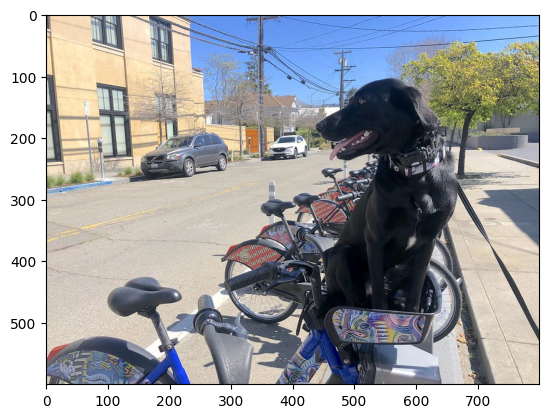

In [15]:
# Read the image
image = cv2.imread(filename=str(image_path))

# The network expects images in RGB format
image = cv2.cvtColor(image, code=cv2.COLOR_BGR2RGB)

# Resize the image to the network input shape
resized_image = cv2.resize(src=image, dsize=(255, 255))

# Transpose the image to the network input shape
network_input_image = np.expand_dims(resized_image, 0)

# Show the image
plt.imshow(image)

In [16]:
inference_result = compiled_model(network_input_image)

In [17]:
_, detection_boxes, detection_classes, _, detection_scores, num_detections, _, _ = model_outputs

image_detection_boxes = inference_result[detection_boxes]
print("image_detection_boxes:", image_detection_boxes)

image_detection_classes = inference_result[detection_classes]
print("image_detection_classes:", image_detection_classes)

image_detection_scores = inference_result[detection_scores]
print("image_detection_scores:", image_detection_scores)

image_num_detections = inference_result[num_detections]
print("image_detections_num:", image_num_detections)

# Alternatively, inference result data can be extracted by model output name with `.get()` method
assert (inference_result[detection_boxes] == inference_result.get("detection_boxes")).all(), "extracted inference result data should be equal"

image_detection_boxes: [[[0.16453627 0.54612625 0.8953375  0.8546991 ]
  [0.6721998  0.01249561 0.98444647 0.5316879 ]
  [0.49109885 0.01171527 0.9804508  0.88644964]
  ...
  [0.5012432  0.5489591  0.60305756 0.61094964]
  [0.45808488 0.36198813 0.8841142  0.83722156]
  [0.4652153  0.02054657 0.48204365 0.04388366]]]
image_detection_classes: [[18.  2.  2.  3.  2.  8.  2.  2.  3.  2.  4.  4.  2.  4. 16.  1.  1. 27.
   2.  8. 62.  2.  2.  4.  4.  2. 41. 18.  4.  2.  4. 18.  2.  2.  4. 27.
   2.  2. 27.  2.  1.  1. 16.  2.  2.  2. 16.  2.  2.  4.  2.  1. 33.  4.
  15.  2.  3.  2.  2.  1.  2.  1.  4.  2.  3. 11.  4. 35. 40.  4.  1. 62.
   2.  2.  4. 36.  4. 36.  1. 31. 77.  2. 36.  1. 51.  1. 34.  3. 90.  2.
   3.  2.  1.  2.  2.  1.  1.  2.  1.  4. 18.  2.  2.  3. 31.  1. 41.  1.
   2.  2. 33. 41.  3. 31.  1.  3. 36. 27. 27. 15.  4.  4. 15.  3.  2. 37.
   1. 35. 27.  4. 36. 88.  4.  2.  3. 15.  2.  4.  2.  1.  3.  3. 27.  4.
   4. 44. 16.  1.  1. 23.  4.  3.  1.  4.  4. 62. 15. 36. 77.  3

In [18]:
import random
from typing import Optional


def add_detection_box(box: np.ndarray, image: np.ndarray, label: Optional[str] = None) -> np.ndarray:
    """
    Helper function for adding single bounding box to the image

    Parameters
    ----------
    box : np.ndarray
        Bounding box coordinates in format [ymin, xmin, ymax, xmax]
    image : np.ndarray
        The image to which detection box is added
    label : str, optional
        Detection box label string, if not provided will not be added to result image (default is None)

    Returns
    -------
    np.ndarray
        NumPy array including both image and detection box

    """
    ymin, xmin, ymax, xmax = box
    point1, point2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
    box_color = [random.randint(0, 255) for _ in range(3)]
    line_thickness = round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1

    cv2.rectangle(img=image, pt1=point1, pt2=point2, color=box_color, thickness=line_thickness, lineType=cv2.LINE_AA)

    if label:
        font_thickness = max(line_thickness - 1, 1)
        font_face = 0
        font_scale = line_thickness / 3
        font_color = (255, 255, 255)
        text_size = cv2.getTextSize(text=label, fontFace=font_face, fontScale=font_scale, thickness=font_thickness)[0]
        # Calculate rectangle coordinates
        rectangle_point1 = point1
        rectangle_point2 = (point1[0] + text_size[0], point1[1] - text_size[1] - 3)
        # Add filled rectangle
        cv2.rectangle(img=image, pt1=rectangle_point1, pt2=rectangle_point2, color=box_color, thickness=-1, lineType=cv2.LINE_AA)
        # Calculate text position
        text_position = point1[0], point1[1] - 3
        # Add text with label to filled rectangle
        cv2.putText(img=image, text=label, org=text_position, fontFace=font_face, fontScale=font_scale, color=font_color, thickness=font_thickness, lineType=cv2.LINE_AA)
    return image

In [19]:
from typing import Dict

from openvino.runtime.utils.data_helpers import OVDict


def visualize_inference_result(inference_result: OVDict, image: np.ndarray, labels_map: Dict, detections_limit: Optional[int] = None):
    """
    Helper function for visualizing inference result on the image

    Parameters
    ----------
    inference_result : OVDict
        Result of the compiled model inference on the test image
    image : np.ndarray
        Original image to use for visualization
    labels_map : Dict
        Dictionary with mappings of detection classes numbers and its names
    detections_limit : int, optional
        Number of detections to show on the image, if not provided all detections will be shown (default is None)
    """
    detection_boxes: np.ndarray = inference_result.get("detection_boxes")
    detection_classes: np.ndarray = inference_result.get("detection_classes")
    detection_scores: np.ndarray = inference_result.get("detection_scores")
    num_detections: np.ndarray = inference_result.get("num_detections")

    detections_limit = int(
        min(detections_limit, num_detections[0])
        if detections_limit is not None
        else num_detections[0]
    )

    # Normalize detection boxes coordinates to original image size
    original_image_height, original_image_width, _ = image.shape
    normalized_detection_boxex = detection_boxes[::] * [
        original_image_height,
        original_image_width,
        original_image_height,
        original_image_width,
    ]

    image_with_detection_boxex = np.copy(image)

    for i in range(detections_limit):
        detected_class_name = labels_map[int(detection_classes[0, i])]
        score = detection_scores[0, i]
        label = f"{detected_class_name} {score:.2f}"
        add_detection_box(
            box=normalized_detection_boxex[0, i],
            image=image_with_detection_boxex,
            label=label,
        )

    plt.imshow(image_with_detection_boxex)

In [20]:
coco_labels_file_path = Path("./data/coco_91cl.txt")

download_file(
    url="https://raw.githubusercontent.com/openvinotoolkit/open_model_zoo/master/data/dataset_classes/coco_91cl.txt",
    filename=coco_labels_file_path.name,
    directory=coco_labels_file_path.parent,
)

data/coco_91cl.txt:   0%|          | 0.00/421 [00:00<?, ?B/s]

PosixPath('/content/data/coco_91cl.txt')

In [21]:
with open(coco_labels_file_path, "r") as file:
    coco_labels = file.read().strip().split("\n")
    coco_labels_map = dict(enumerate(coco_labels, 1))

print(coco_labels_map)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplan', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 12: 'street sign', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 26: 'hat', 27: 'backpack', 28: 'umbrella', 29: 'shoe', 30: 'eye glasses', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 45: 'plate', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 66: 'mirror', 67: 'dining table', 68: 'window', 69: 'des

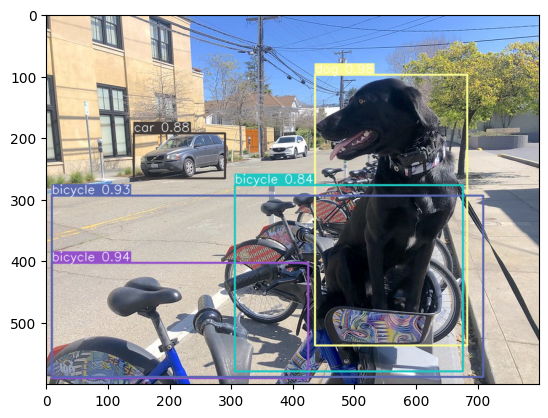

In [22]:
visualize_inference_result(
    inference_result=inference_result,
    image=image,
    labels_map=coco_labels_map,
    detections_limit=5,
)